# Brand Analysis

My goal in this report is to identify the smaller brands which are attractive to invest in. I will evaluate brands on Measure of Performance weekly; number of stores selling the product and their future growth potential Let's Go!

In [8]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
 

In [1]:
import pandas as pd
from math import ceil
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from fbprophet import Prophet

In [2]:
mpl.rcParams['figure.figsize'] = [15.0, 8.0]

In [3]:
# Reading the dataset2
data= pd.read_csv("C:/Users/dexter/Desktop/CircleUP/cider_anon_final.csv")

In [4]:
data.head()

,upc_UUID,retailer_UUID,brand_UUID,corporate_owner_UUID,size_of_upc,shape_of_package,time_period,total_number_of_stores_retailer,no_of_units_sold,dollars_sold,avg_unit_price,sub_category,avg_no_of_store_selling
0,25acf29c-50f1-4a37-98cc-284be6a97e92,6dc533da-970c-437e-a4a1-c5ba458ff3d0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-03,NaN,0.0,0.00,NaN,ALCOHOLIC CIDER,NaN
1,25acf29c-50f1-4a37-98cc-284be6a97e92,64680bfb-ee5a-4011-811c-96e60074dfff,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-03,61.0,1.0,8.99,8.9900,ALCOHOLIC CIDER,1.42679
2,25acf29c-50f1-4a37-98cc-284be6a97e92,368d321b-23a1-4665-a24e-ce44bb1ed887,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-10,NaN,0.0,0.00,NaN,ALCOHOLIC CIDER,NaN
3,25acf29c-50f1-4a37-98cc-284be6a97e92,13548ee8-d07d-4c35-a14b-1efbb8663ab0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-10,229.0,50.0,481.88,9.6376,ALCOHOLIC CIDER,30.80508
4,25acf29c-50f1-4a37-98cc-284be6a97e92,6dc533da-970c-437e-a4a1-c5ba458ff3d0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-10,NaN,0.0,0.00,NaN,ALCOHOLIC CIDER,NaN



dollars_sold column is derived from no_of_units_sold and avg_unit_price. I will not include these 2 columns in my analysis as it is represented by dollars_sold. Same can be said for avg_no_of_store_selling and total_number_of_stores_retailer.

Besides, there are NA values in the dataset

In [5]:
data.dtypes

upc_UUID                            object
retailer_UUID                       object
brand_UUID                          object
corporate_owner_UUID                object
size_of_upc                         object
shape_of_package                    object
time_period                         object
total_number_of_stores_retailer    float64
no_of_units_sold                   float64
dollars_sold                       float64
avg_unit_price                     float64
sub_category                        object
avg_no_of_store_selling            float64
dtype: object

# Data Preprocessing

Let us determine How many unique brands are there in the dataset

In [6]:
#converting to datetime
data['time_period'] = pd.to_datetime(data['time_period']) #converting to datetime

In [7]:
#Number of brands
len(set(data["brand_UUID"]))


238

Do we have missing values in the dataset?

In [8]:
# There is no use of this columns as the whole dataset is of only 1 category
del data["sub_category"]


In [9]:
data.isna().sum()

upc_UUID                                0
retailer_UUID                           0
brand_UUID                              0
corporate_owner_UUID                    0
size_of_upc                             0
shape_of_package                        0
time_period                             0
total_number_of_stores_retailer    107168
no_of_units_sold                        0
dollars_sold                            0
avg_unit_price                     107168
avg_no_of_store_selling            107168
dtype: int64

Just Curious, let us find the rows where number of units sold are zero.

In [10]:
stores_not_selling= data[data["no_of_units_sold"]== 0]

In [11]:
stores_not_selling.isna().sum()

upc_UUID                                0
retailer_UUID                           0
brand_UUID                              0
corporate_owner_UUID                    0
size_of_upc                             0
shape_of_package                        0
time_period                             0
total_number_of_stores_retailer    107168
no_of_units_sold                        0
dollars_sold                            0
avg_unit_price                     107168
avg_no_of_store_selling            107168
dtype: int64

Great we dont have data where there are no units sold. This means this can be categorize as inventory which stores are finding them to sell. Let us look at number of brands do these product belong to.

In [12]:
len(set(stores_not_selling["corporate_owner_UUID"]))

188

If these stores are not selling anything; it is fair to assume that avg_unit_price and avg_store_selling will be zero, Hence the NA values

In [13]:
#Fill these 2 columns with 0 whenever NA
data["avg_unit_price"]= data.avg_unit_price.fillna(value=0)


data["avg_no_of_store_selling"]= data.avg_no_of_store_selling.fillna(value=0)


Filter out the relevant columns in stores not selling

In [14]:
stores_not_selling=stores_not_selling[["upc_UUID","brand_UUID","corporate_owner_UUID","retailer_UUID"]]

We will find the number of retailers (retailer_UUID) agregated by transactions of product (upc_UUID) and the brands (brand_UUID) where the products are not being sold. the result output is appended to NAN values in number of retailers.

In [15]:
#Aggregate by brand and transaction upc id
number_of_stores_nosales= stores_not_selling.groupby(["brand_UUID","upc_UUID"], as_index= False)["retailer_UUID"].count()



df1=data[["upc_UUID", "brand_UUID"]]
df2= df1.merge(number_of_stores_nosales, on=["upc_UUID", "brand_UUID"], how= "left")
df2.head()

#df2.rename(columns={"upc_UUID": "temp_upc", "brand_UUID": "temp_brand", "retailer_UUID":"temp_retailer"})
df2.columns=["temp_upc", "temp_brand", "temp_retailer"]
#df2.head()


data["temp_upc"]=df2["temp_upc"]
data["temp_brand"]=df2["temp_brand"]
data["temp_retailer"]=df2["temp_retailer"]
#data.head()

data['total_number_of_stores_retailer'] = data.apply(
    lambda row: row["temp_retailer"] if np.isnan(row['total_number_of_stores_retailer'])  else row['total_number_of_stores_retailer'],
    axis=1)

del data["temp_upc"]
del data["temp_brand"]
del data["temp_retailer"]



In [16]:
data.head()

,upc_UUID,retailer_UUID,brand_UUID,corporate_owner_UUID,size_of_upc,shape_of_package,time_period,total_number_of_stores_retailer,no_of_units_sold,dollars_sold,avg_unit_price,avg_no_of_store_selling
0,25acf29c-50f1-4a37-98cc-284be6a97e92,6dc533da-970c-437e-a4a1-c5ba458ff3d0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-03,433.0,0.0,0.00,0.0000,0.00000
1,25acf29c-50f1-4a37-98cc-284be6a97e92,64680bfb-ee5a-4011-811c-96e60074dfff,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-03,61.0,1.0,8.99,8.9900,1.42679
2,25acf29c-50f1-4a37-98cc-284be6a97e92,368d321b-23a1-4665-a24e-ce44bb1ed887,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-10,433.0,0.0,0.00,0.0000,0.00000
3,25acf29c-50f1-4a37-98cc-284be6a97e92,13548ee8-d07d-4c35-a14b-1efbb8663ab0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-10,229.0,50.0,481.88,9.6376,30.80508
4,25acf29c-50f1-4a37-98cc-284be6a97e92,6dc533da-970c-437e-a4a1-c5ba458ff3d0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-10,433.0,0.0,0.00,0.0000,0.00000


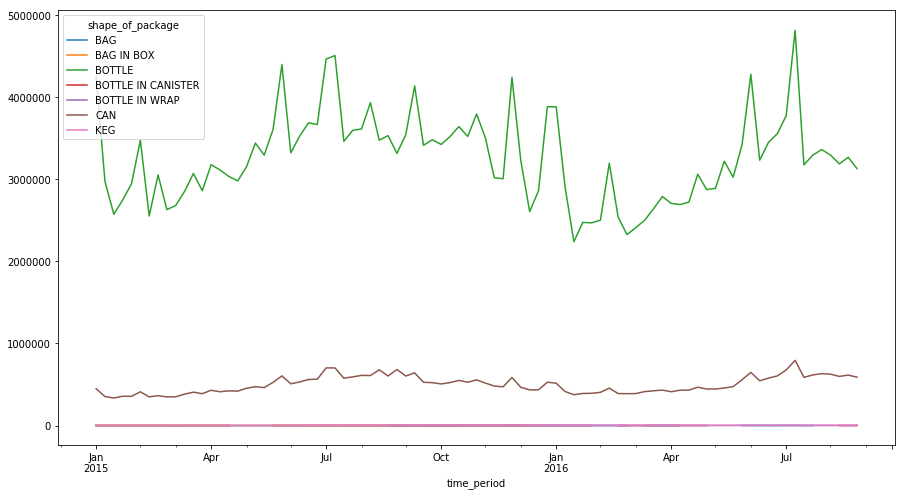

In [17]:
# plot data


data.groupby(['time_period','shape_of_package']).sum()['dollars_sold'].unstack().plot()

plt.show()

## Measure of Performance

My measure of performance will be weekly running sales of each brand

Let us calculate the dollars sold on weekly basis by each brand

In [18]:
# Aggregate by brand and time period
grouped = pd.DataFrame(data.groupby(['brand_UUID', 'time_period'])['dollars_sold'].sum().reset_index())
grouped.head()

,brand_UUID,time_period,dollars_sold
0,0093267c-f791-4563-ad61-163f29c45a49,2015-01-03,481006.173
1,0093267c-f791-4563-ad61-163f29c45a49,2015-01-10,324592.773
2,0093267c-f791-4563-ad61-163f29c45a49,2015-01-17,305561.541
3,0093267c-f791-4563-ad61-163f29c45a49,2015-01-24,325578.691
4,0093267c-f791-4563-ad61-163f29c45a49,2015-01-31,349518.565


Brand_UUID is difficult to understand for me (Looks like API key). Let us convert it into more comprehensible form

In [19]:
grouped["brand_UUID"] = grouped["brand_UUID"].astype('category')
grouped["brand_key"] = grouped["brand_UUID"].cat.codes
cut_brands=[238,207,75,9]     # brands dont have enough data

grouped= grouped[~grouped.brand_key.isin(cut_brands)] # note the ~ operator


In [20]:
grouped.head()

,brand_UUID,time_period,dollars_sold,brand_key
0,0093267c-f791-4563-ad61-163f29c45a49,2015-01-03,481006.173,0
1,0093267c-f791-4563-ad61-163f29c45a49,2015-01-10,324592.773,0
2,0093267c-f791-4563-ad61-163f29c45a49,2015-01-17,305561.541,0
3,0093267c-f791-4563-ad61-163f29c45a49,2015-01-24,325578.691,0
4,0093267c-f791-4563-ad61-163f29c45a49,2015-01-31,349518.565,0


Here we go. We will use the brand key as an alias for brand_UUID for our future analysis.
## Visualizations
Let us see some interesting Visualization

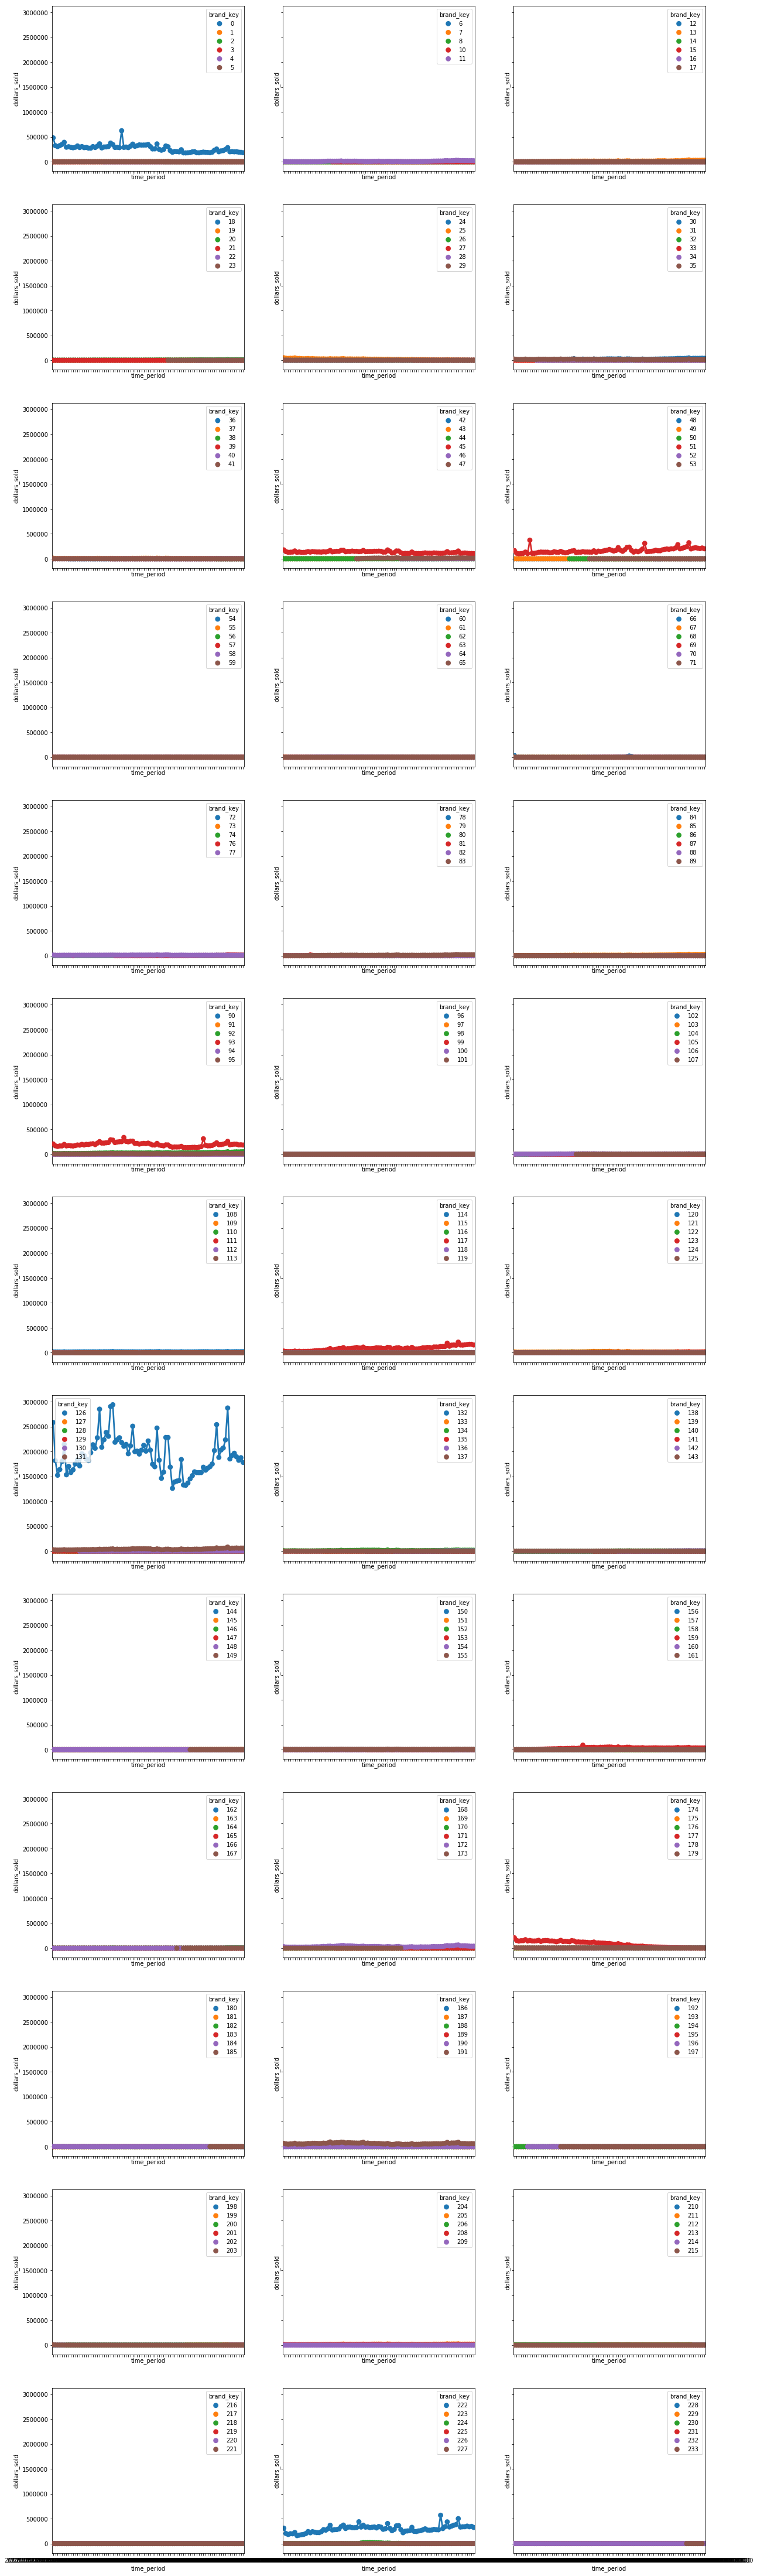

In [21]:
fig, axes = plt.subplots(nrows=13, ncols=3, sharex=True, sharey=True, figsize=(20,80))
num_graph = 40
brand_per_graph = ceil(grouped.brand_key.max() / num_graph)
count = 0
for i in range(13):
    for j in range(3):
        sns.pointplot(x='time_period', y='dollars_sold', hue='brand_key', data=grouped[np.logical_and(count*brand_per_graph <= grouped['brand_key'], grouped['brand_key'] < (count+1)*brand_per_graph)], ax=axes[i][j])
        count += 1


Not many brands are making more than 500k weekly other than brand 126.Brand 126 is making sales of 1.5M weekly from 2015-2016 which makes it in a category of its own based on weekly sales. There are 6 brands that are doing between 100k- 500k of weekly sales. All the other brands are doing under 100k of weekly sales. Hence we classify our brands on this scale as High, Medium, Small brands.

To know the performance of smaller brands better, let us remove Brand 126 and look at the graph again.

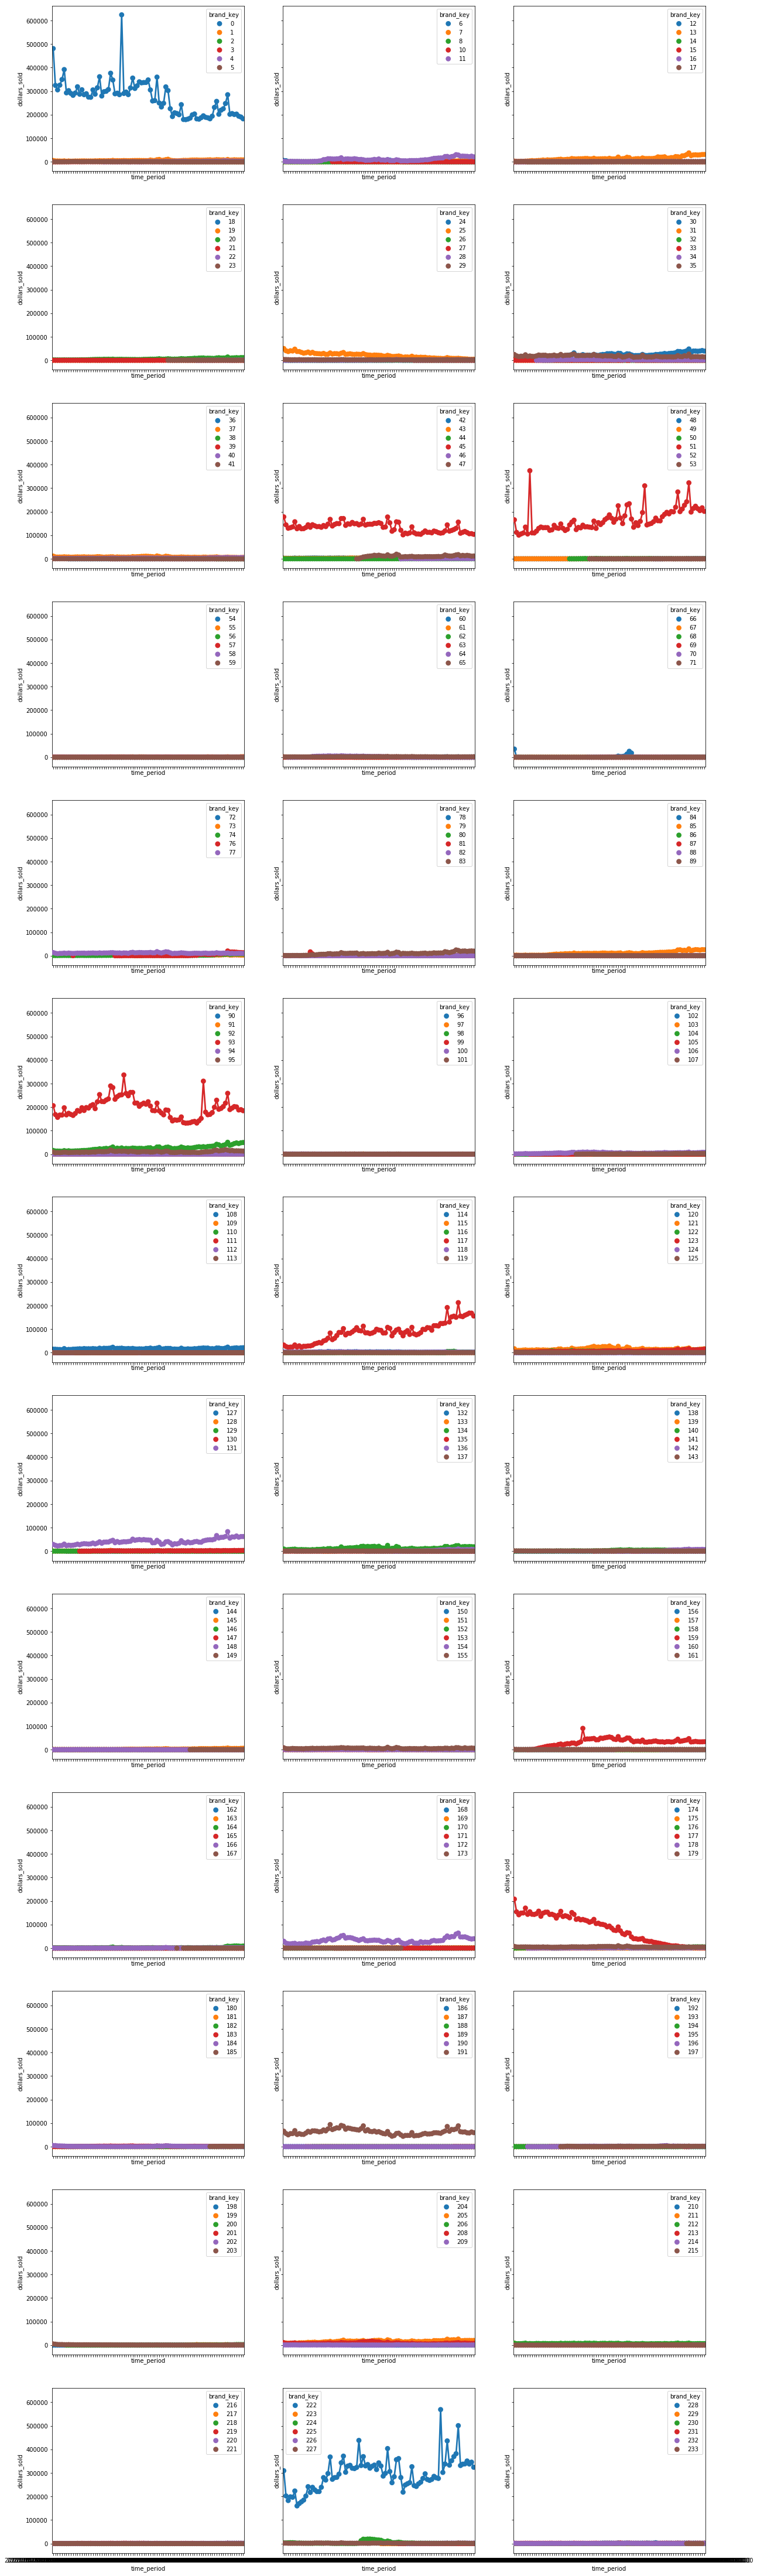

In [22]:
grouped_medium= grouped[grouped["brand_key"]!=126]
fig, axes = plt.subplots(nrows=13, ncols=3, sharex=True, sharey=True, figsize=(20,80))
num_graph = 40
brand_per_graph = ceil(grouped_medium.brand_key.max() / num_graph)
count = 0
for i in range(13):
    for j in range(3):
        sns.pointplot(x='time_period', y='dollars_sold', hue='brand_key', data=grouped_medium[np.logical_and(count*brand_per_graph <= grouped_medium['brand_key'], grouped_medium['brand_key'] < (count+1)*brand_per_graph)], ax=axes[i][j])
        count += 1

Most of the smaller brands are doing less than 100k weekly.We can see brand 0 and 177 are on the downward trajectory. Probably these companies are failing. On the other hand, Brands 51, 117, 222 and 131 shows growth which makes their brand attractive to invest. Brands like 93 and 172 shows seasonal sales which make them attractive in specific part of the year.
### Smaller Brands
Let us see what's happening with smaller brands

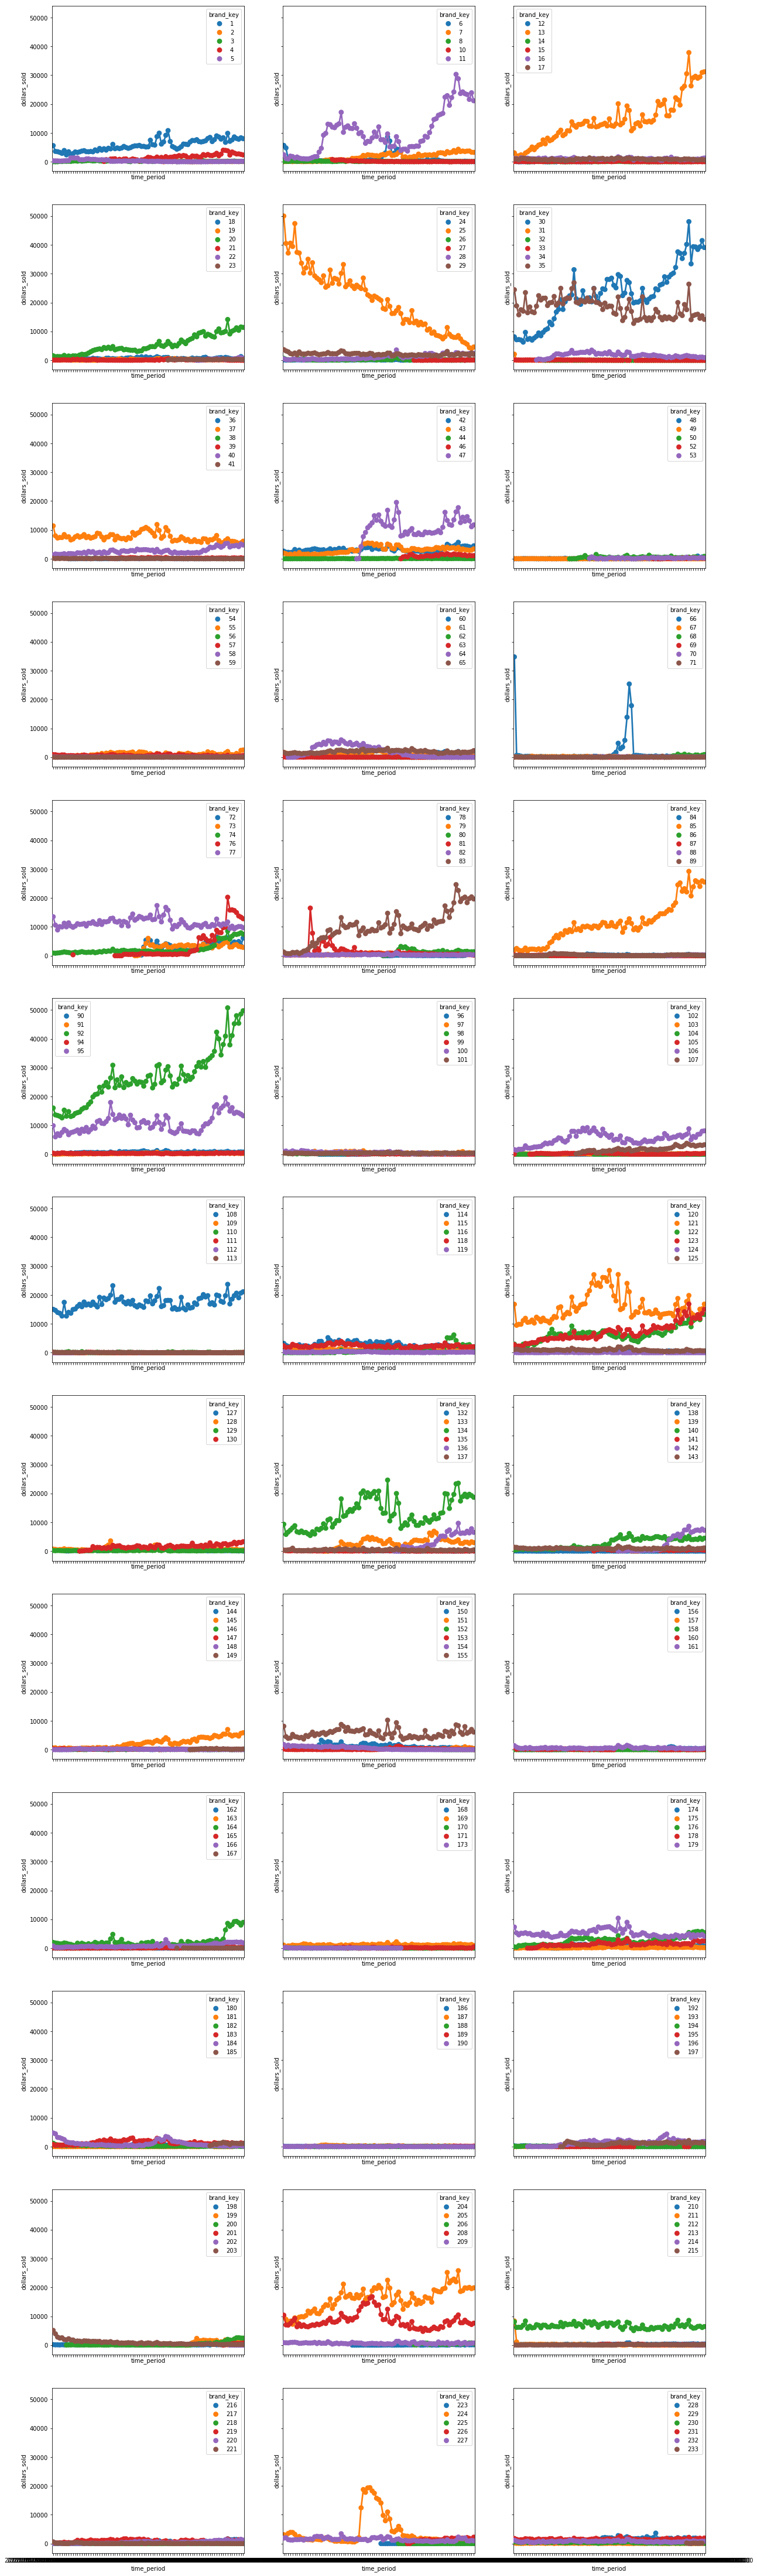

In [23]:
brand_medium=[0,45,51,93,117,177,191,222,131,159,172,131]
#cut_brands=[238,207,75,9]     # brands dont have enough data
#brand_medium+= cut_brands
grouped_small= grouped_medium[~grouped_medium.brand_key.isin(brand_medium)] # note the ~ operator


fig, axes = plt.subplots(nrows=13, ncols=3, sharex=True, sharey=True, figsize=(20,80))
num_graph = 40
brand_per_graph = ceil(grouped_small.brand_key.max() / num_graph)
count = 0
for i in range(13):
    for j in range(3):
        sns.pointplot(x='time_period', y='dollars_sold', hue='brand_key', data=grouped_small[np.logical_and(count*brand_per_graph <= grouped_small['brand_key'], grouped_small['brand_key'] < (count+1)*brand_per_graph)], ax=axes[i][j])
        count += 1

It is fair to say the brand which are doing less than 2000 dollars/week are too early to invest in. As their brands have not reached the threshold point to scale up. In other words these brands can be considered as a hobby rather than a business.

#### More Insights
From the above plots we can surely determine which brands are good to invest in brand 11, 13, 30, 47, 83, 85, 92, 95, 123,and 205 show considerable growth

In [24]:
performance_df= grouped.groupby("brand_key", as_index=False)["dollars_sold"].mean()
performance_df = performance_df.rename(columns={'dollars_sold': 'weekly_running_rate'})
performance_df.head()

,brand_key,weekly_running_rate
0,0,272356.724414
1,1,5793.124494
2,2,113.971622
3,3,235.008276
4,4,1687.247031


## Measure of Growth 

My idea for the growth will be (sales in next quarter by each brand - sales in last quarter by each brand) 

We will forecast revenues for each brand in the next quarter by using a forecasting tool by Facebook Prophet (Time series)

In [25]:
df2=grouped[["time_period","dollars_sold", "brand_key"]]  # getting the necessary columns

In [26]:
len(df2["brand_key"].unique())  # total number of brands

235

We will store the predictions into a dictionary where the keys will be brand number and values will be a time series dataframe

In [27]:
# Facebook Prophet algorithm


prediction = {}   
df2 = df2.rename(columns={'time_period': 'ds','dollars_sold': 'y', 'brand_key': 'brand'})
lst= df2["brand"].unique()

for brands in lst:
    brand_df = df2.loc[df2['brand'] == brands]
    brand_df.dropna(inplace=True)
    my_model = Prophet(weekly_seasonality= True,yearly_seasonality=True) #include the seasonalities
    my_model.fit(brand_df)
    future_dates = my_model.make_future_dataframe(periods=14, freq="w") # 14 weeks forecast ~ 1 quarter
    forecast = my_model.predict(future_dates)
    forecast=forecast[["ds","yhat"]]
    #forecast["brand_key"]= brands
    prediction[brands] = forecast           # get predictions with brand as key and forecasted revenue dataframe as value


C:\Users\dexter\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\dexter\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True 

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 14.0.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fb

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 2.0.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbp

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 4.0.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 21.0.
INFO:fbprophet.forecaster:Disabling daily seasonality. Ru

In [34]:
#We will quickly extract the keys and append into the column of dictionary values by the following code
for key, value in prediction.items():
    value["brand_key"]= key



The above dictionary values shows you what lies within. ex: the first 100 rows in this output is the predicted weekly sales corresponding to brand 0, Next 100 is for Brand 1 and so on

To undestand this better, I have generated the plot below to show how the forecast vary with time. Please note the shaded region are the upper and the lower estimate of the predicted sales for brand 0. Besides; the revenue forecasted is the time period from 08/28/2016 to 11/27/2016 (3 months)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\dexter\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


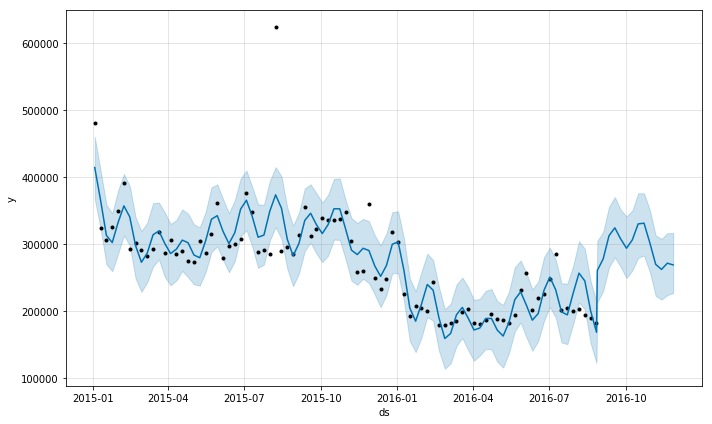

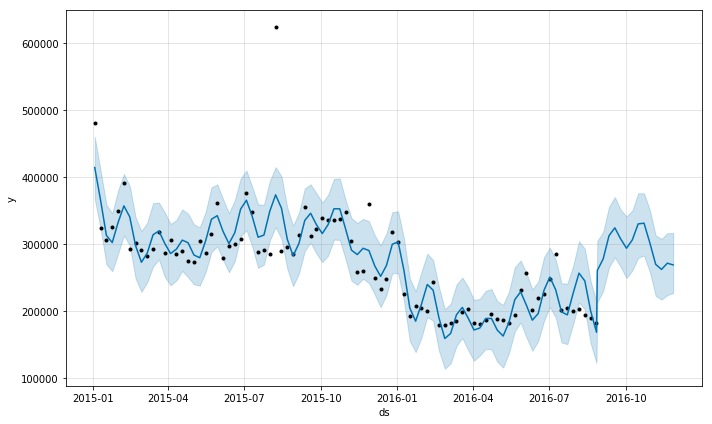

In [33]:

df3 = df2.rename(columns={'time_period': 'ds','dollars_sold': 'y', 'brand_key': 'brand'})
brand_df3 = df3.loc[df3['brand'] == 0]
        
my_model = Prophet(weekly_seasonality= True, yearly_seasonality=True)
my_model.fit(brand_df3)
future_dates = my_model.make_future_dataframe(periods=14, freq= "w") # 14 weeks forecast ~ 1 quarter
forecast = my_model.predict(future_dates)
my_model.plot(forecast)


Some of the brands have forecasted negative sales for the nest quarter. We need to change these values to 0

In [35]:
#Creating a new dataframe
prediction_df = pd.DataFrame( columns=["ds","yhat","brand_key"])
prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])
prediction_df["brand_key"] = prediction_df["brand_key"].astype(int)
#prediction_df.head()

#Appending dictionary values for each brand into the new dataframe
for dataframe in prediction.values():
    prediction_df= pd.concat([prediction_df,dataframe], ignore_index=False, axis=0)
#prediction_df.shape



# Getting negative predictive values to zero
prediction_df["yhat"]= prediction_df["yhat"].apply(lambda x: 0 if x<0 else x)

prediction_df[prediction_df["yhat"]<0]     #just checking

,ds,yhat,brand_key


In [38]:
prediction_df.head(10)

,ds,yhat,brand_key
0,2015-01-03,414392.599951,0
1,2015-01-10,365568.529258,0
2,2015-01-17,313004.974855,0
3,2015-01-24,302406.391431,0
4,2015-01-31,332433.068760,0
5,2015-02-07,357167.417971,0
6,2015-02-14,340682.125053,0
7,2015-02-21,297748.640177,0
8,2015-02-28,273005.655857,0
9,2015-03-07,286738.090967,0


Let us calculate the cumulative sales of each brand in the next quarter

In [39]:
# renaming our prediction dataset

prediction_df = prediction_df.rename(columns={'ds': 'time_period','yhat': 'sales_next_quarter', 'brand_key': 'brand_key'})

#Filtering the prediction dataset for sales in next quarter as predicted by model starting from 2016-08-27

prediction_df_quarter = prediction_df[(prediction_df['time_period'] > '2016-08-27') & (prediction_df['time_period'] <= '2016-11-30')]
cumulative_sum_next_quarter= prediction_df_quarter.groupby("brand_key", as_index= False)["sales_next_quarter"].sum()
cumulative_sum_next_quarter.head()


,brand_key,sales_next_quarter
0,0,4.120085e+06
1,1,1.566982e+05
2,2,1.400157e+03
3,3,3.088606e+02
4,4,4.285146e+04


Let us calculate the cumulative sales of each brand in the last quarter

In [40]:
#Filtering the grouped dataset for sales in last quarter from where the forecast began
grouped_last_quarter = grouped[(grouped['time_period'] > '2016-05-20') & (grouped['time_period'] <= '2016-08-27')]

# Sales of last quarter aggregated by brand
cumulative_sum_last_quarter= grouped_last_quarter.groupby("brand_key", as_index= False)["dollars_sold"].sum()
cumulative_sum_last_quarter = cumulative_sum_last_quarter.rename(columns={'dollars_sold': 'sales_last_quarter' })
cumulative_sum_last_quarter.head()

,brand_key,sales_last_quarter
0,0,3238071.068
1,1,120807.239
2,2,1625.660
3,3,2557.928
4,4,43345.270


I will consider brands having 0 sales in the last month to be dead. Hence it makes sense to remove from the analysis. Brand 188 will be removed from the final dataset. In other words this brand is not good for investing.

In [41]:
# Last month aggregated sales
grouped_last_month = grouped[(grouped['time_period'] > '2016-07-30') & (grouped['time_period'] <= '2016-08-27')]

# Sales of last quarter aggregated by brand
cumulative_sum_last_month= grouped_last_month.groupby("brand_key", as_index= False)["dollars_sold"].sum()
cumulative_sum_last_month = cumulative_sum_last_month.rename(columns={'dollars_sold': 'sales_last_month' })
#cumulative_sum_last_month.head()

fallen_brands=cumulative_sum_last_month[cumulative_sum_last_month["sales_last_month"]==0]
fallen_brands.head()

,brand_key,sales_last_month
181,188,0.0


Calculating Growth by subtracting sales in last quarter from forecasted quarter

In [42]:
#Merging both datasets on brand_key
growth_df= cumulative_sum_last_quarter.merge(cumulative_sum_next_quarter, on="brand_key", how="inner")

# Calculating Growth for each brand
growth_df["Growth_sales"]= growth_df["sales_next_quarter"]-growth_df["sales_last_quarter"]
growth_df.head()

,brand_key,sales_last_quarter,sales_next_quarter,Growth_sales
0,0,3238071.068,4.120085e+06,882013.669785
1,1,120807.239,1.566982e+05,35890.992467
2,2,1625.660,1.400157e+03,-225.502624
3,3,2557.928,3.088606e+02,-2249.067366
4,4,43345.270,4.285146e+04,-493.814371


In [43]:
fallen= growth_df[growth_df["sales_last_quarter"]==0]
fallen.head()

,brand_key,sales_last_quarter,sales_next_quarter,Growth_sales


In [44]:
features_df= performance_df.merge(growth_df, on="brand_key", how="inner") #Inner join will automatically remove brand 181
features_df.head()

,brand_key,weekly_running_rate,sales_last_quarter,sales_next_quarter,Growth_sales
0,0,272356.724414,3238071.068,4.120085e+06,882013.669785
1,1,5793.124494,120807.239,1.566982e+05,35890.992467
2,2,113.971622,1625.660,1.400157e+03,-225.502624
3,3,235.008276,2557.928,3.088606e+02,-2249.067366
4,4,1687.247031,43345.270,4.285146e+04,-493.814371


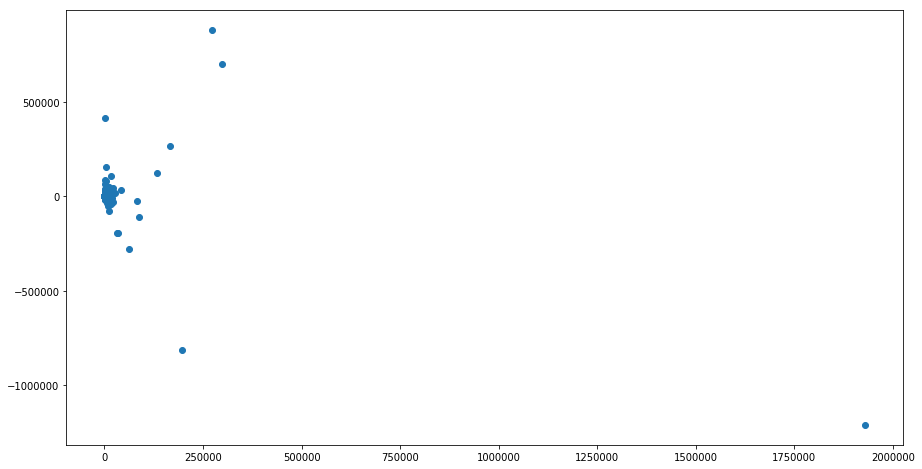

In [45]:
plt.scatter(features_df["weekly_running_rate"],features_df["Growth_sales"])

the data point on the bottom right corner is brand 126 which was shooting out of the park when considered by weekly running rate. However the growth forecast for this brand is falling by 1M dollars in next quarter. 
#### My Gut Feeling 
However it does not matter as the decision boundary will be a diagonal joining 250000 of growth sales and 100000 of weekly running rate. All the brands on the right side of the decision boundary will be good to invest. Brand 126 is on right bottom corner; hence it is good to invest


## Brand Attractiveness

The first idea that came to my mind was a linear model that takes into account of Growth, weekly sales and average no of stores selling product. However; in this model we will not be able to identify the weights associated with all these 3 parameters as there is no data on brand attractivenes a.k.a  " Y" Label is not there. Therefore; We will use the Kmeans Unsupervised Learning Algorithm to classify the smaller brands to classify if they are attractive to invest or not


Let us prepare our dataset first.We will get our 3rd parameter (avg_no_of_store_selling) into our features dataset.

In [46]:
# Mapping our brand keys to our original data to perform the aggregate afterwards
df5= grouped[["brand_UUID","brand_key"]]
data2= data.merge(df5, on="brand_UUID", how= "inner")
data2.head()



,upc_UUID,retailer_UUID,brand_UUID,corporate_owner_UUID,size_of_upc,shape_of_package,time_period,total_number_of_stores_retailer,no_of_units_sold,dollars_sold,avg_unit_price,avg_no_of_store_selling,brand_key
0,25acf29c-50f1-4a37-98cc-284be6a97e92,6dc533da-970c-437e-a4a1-c5ba458ff3d0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-03,433.0,0.0,0.0,0.0,0.0,121
1,25acf29c-50f1-4a37-98cc-284be6a97e92,6dc533da-970c-437e-a4a1-c5ba458ff3d0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-03,433.0,0.0,0.0,0.0,0.0,121
2,25acf29c-50f1-4a37-98cc-284be6a97e92,6dc533da-970c-437e-a4a1-c5ba458ff3d0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-03,433.0,0.0,0.0,0.0,0.0,121
3,25acf29c-50f1-4a37-98cc-284be6a97e92,6dc533da-970c-437e-a4a1-c5ba458ff3d0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-03,433.0,0.0,0.0,0.0,0.0,121
4,25acf29c-50f1-4a37-98cc-284be6a97e92,6dc533da-970c-437e-a4a1-c5ba458ff3d0,76e7860b-26d7-4f32-b84a-4001e31951f0,b8e4d1e5-e7ab-413f-bcfa-35e3b0db4bf8,12 FLUID OUNCE,BOTTLE,2015-01-03,433.0,0.0,0.0,0.0,0.0,121


In [47]:
# Calculating the aggregate mean of avg_n0_of_store_selling
grouped4= data2.groupby('brand_key', as_index=False)['avg_no_of_store_selling'].mean()
grouped4.head()

,brand_key,avg_no_of_store_selling
0,0,23.282811
1,1,40.502555
2,2,5.169471
3,3,5.026763
4,4,6.519539


In [48]:
#Getting the parameter into our features dataset
features_df=features_df.merge(grouped4, on="brand_key", how="inner")
features_df.head()

,brand_key,weekly_running_rate,sales_last_quarter,sales_next_quarter,Growth_sales,avg_no_of_store_selling
0,0,272356.724414,3238071.068,4.120085e+06,882013.669785,23.282811
1,1,5793.124494,120807.239,1.566982e+05,35890.992467,40.502555
2,2,113.971622,1625.660,1.400157e+03,-225.502624,5.169471
3,3,235.008276,2557.928,3.088606e+02,-2249.067366,5.026763
4,4,1687.247031,43345.270,4.285146e+04,-493.814371,6.519539


Great, We have all the parameters we need to identify brand attractiveness. Now we need to filter out the smaller brands. It is assumed that all the medium and large brands are investible. In other words they are attractive

In [49]:
# Filtering smaller brands
brand_medium_and_large=[0,45,51,93,117,177,191,222,131,159,172,131,126,188]

features_df= features_df[~features_df.brand_key.isin(brand_medium_and_large)] # note the ~ operator

In [50]:
# Data Preprocessing
features=features_df.set_index("brand_key")

features=features_df[["weekly_running_rate","Growth_sales","avg_no_of_store_selling"]]

# Normalize the dataset
features_df_norm=features.apply(lambda x: (x - np.mean(x)) / (np.std(x)))

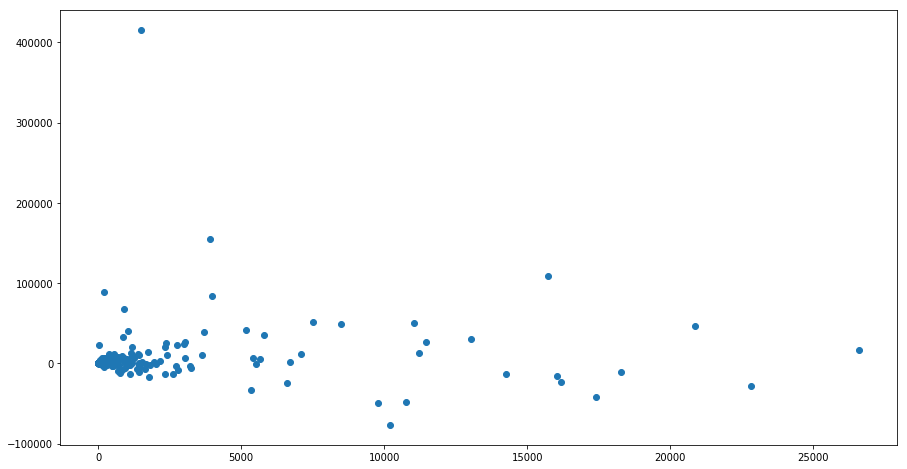

In [51]:
# Let us see how the smaller brands look on 2d plot
plt.scatter(features_df["weekly_running_rate"],features_df["Growth_sales"])

In [52]:
features_df_norm.head()

,weekly_running_rate,Growth_sales,avg_no_of_store_selling
1,0.886074,0.858819,2.518739
2,-0.453491,-0.181320,-0.178178
3,-0.424941,-0.239598,-0.189070
4,-0.082396,-0.189048,-0.075129
5,-0.406986,-0.222375,-0.174231


In [53]:
#Kmeans Algorithm
from sklearn.cluster import KMeans

kb= KMeans(n_clusters=2, init= "random", n_init=10, max_iter=300, random_state=0)

y_db1=kb.fit_predict(features_df_norm)

y_db1

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

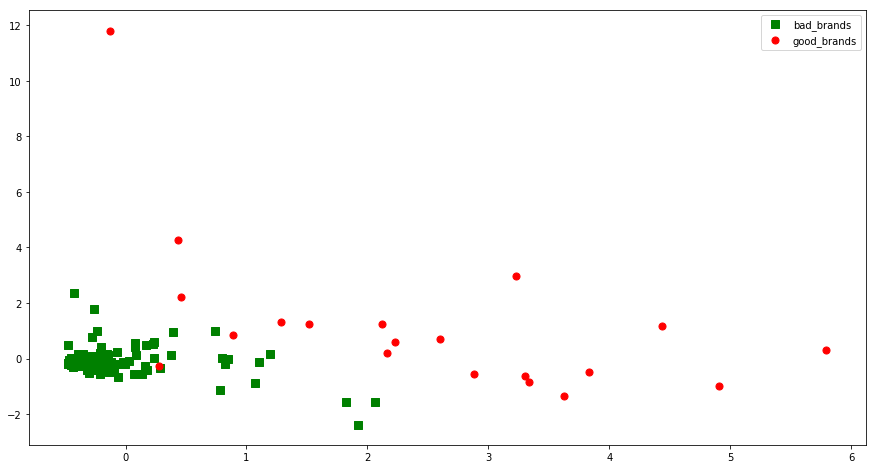

In [54]:
plt.scatter(features_df_norm[y_db1==0]["weekly_running_rate"],features_df_norm[y_db1==0]["Growth_sales"],s=50,c="green",marker="s",label="bad_brands")
plt.scatter(features_df_norm[y_db1==1]["weekly_running_rate"],features_df_norm[y_db1==1]["Growth_sales"],s=50,c="red",marker="o",label="good_brands")

plt.legend()
plt.show()

In [55]:
df6=features_df_norm[y_db1==1]
df6["brand_key"]= df6.index
df6["brand_attactiveness"]="Yes"
df6

C:\Users\dexter\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dexter\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,weekly_running_rate,Growth_sales,avg_no_of_store_selling,brand_key,brand_attactiveness
1,0.886074,0.858819,2.518739,1,Yes
11,2.881115,-0.557825,0.215422,11,Yes
23,4.438573,1.176006,0.513828,23,Yes
28,4.906966,-0.971641,0.450789,28,Yes
33,3.831894,-0.474611,0.298533,33,Yes
35,1.288478,1.325252,0.283797,35,Yes
45,2.121268,1.261776,0.680380,45,Yes
64,-0.124731,11.802223,0.025548,64,Yes
71,0.274894,-0.271007,11.319934,71,Yes
73,0.457689,2.227761,1.586132,73,Yes


In [56]:
df7=features_df_norm[y_db1==0]
df7["brand_key"]= df7.index
df7["brand_attactiveness"]="No"
df7.head(50)

C:\Users\dexter\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dexter\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,weekly_running_rate,Growth_sales,avg_no_of_store_selling,brand_key,brand_attactiveness
2,-0.453491,-0.181320,-0.178178,2,No
3,-0.424941,-0.239598,-0.189070,3,No
4,-0.082396,-0.189048,-0.075129,4,No
5,-0.406986,-0.222375,-0.174231,5,No
6,-0.264335,1.770650,0.543203,6,No
7,-0.069071,0.229081,0.141743,7,No
8,-0.441661,-0.202956,-0.425065,8,No
9,-0.439935,-0.163801,-0.013876,9,No
10,1.923032,-2.386309,0.412016,10,No
12,-0.463370,-0.199613,-0.227116,12,No


# Future Analysis

I have not taken the categorical columns in my analysis. I will like to incorporate size_of_upc and shape of package into our model.
I will like to get VC data on their past investments in this category to match them with the brands in the future by matching risk apetites.

In [57]:
'''
from sklearn.cluster import DBSCAN

db= DBSCAN(eps=1.2, min_samples=10, metric="euclidean")

y_db=db.fit_predict(features_df_norm)



y_db
'''

'\nfrom sklearn.cluster import DBSCAN\n\ndb= DBSCAN(eps=1.2, min_samples=10, metric="euclidean")\n\ny_db=db.fit_predict(features_df_norm)\n\n\n\ny_db\n'

In [58]:
'''
data2["shape_of_package"] = data2["shape_of_package"].astype('category')
data2["shape_of_package_key"] = data2["shape_of_package"].cat.codes

data2["size_of_upc"] = data2["size_of_upc"].astype('category')
data2["size_of_upc_key"] = data2["size_of_upc"].cat.codes

grouped2= data2.groupby('brand_key', as_index=False)['shape_of_package_key'].mean()
grouped3= data2.groupby('brand_key',as_index=False)['size_of_upc_key'].mean()
'''

'\ndata2["shape_of_package"] = data2["shape_of_package"].astype(\'category\')\ndata2["shape_of_package_key"] = data2["shape_of_package"].cat.codes\n\ndata2["size_of_upc"] = data2["size_of_upc"].astype(\'category\')\ndata2["size_of_upc_key"] = data2["size_of_upc"].cat.codes\n\ngrouped2= data2.groupby(\'brand_key\', as_index=False)[\'shape_of_package_key\'].mean()\ngrouped3= data2.groupby(\'brand_key\',as_index=False)[\'size_of_upc_key\'].mean()\n'